In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import *
from src.utils.pre_processing.pre_processing import *
from src.utils.post_preocessing.post_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [2]:
materials = openmc.Materials([B4C_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, LEAD_MATERIAL, STEEL_MATERIAL, CONCRETE_MATERIAL])

In [3]:
CONTROL_RODS_DATA = {
    "rod_1": {"x": 0.0, "y": 0.0, "z": 0.0, "activity" : 4.0e10},
    "rod_2": {"x": 10.0, "y": 0.0, "z": 0.0, "activity" : 4.0e10},
    "rod_3": {"x": -10.0, "y": 0.0, "z": 0.0, "activity" : 4.0e10},
    "rod_4": {"x": 0.0, "y": 10.0, "z": 0.0, "activity" : 4.0e10},
    "rod_5": {"x": 0.0, "y": -10.0, "z": 0.0, "activity" : 4.0e10},
    "rod_6": {"x": 10.0, "y": 10.0, "z": 0.0, "activity" : 6.0e10},
    "rod_7": {"x": -10.0, "y": -10.0, "z": 0.0, "activity" : 6.0e10},
    "rod_8": {"x": 10.0, "y": -10.0, "z": 0.0, "activity" : 6.0e10},
    "rod_9": {"x": -10.0, "y": 10.0, "z": 0.0, "activity" : 6.0e10},
    "rod_10": {"x": 0.0, "y": 20.0, "z": 0.0, "activity" : 2.0e10},
    "rod_11": {"x": 20.0, "y": 0.0, "z": 0.0, "activity" : 2.0e10},
    "rod_12": {"x": -20.0, "y": 0.0, "z": 0.0, "activity" : 2.0e10},
    "rod_13": {"x": 0.0, "y": -20.0, "z": 0.0, "activity" : 2.0e10},
}

TOTAL_ACTIVITY = sum([rod["activity"] for rod in CONTROL_RODS_DATA.values()])

# Surfaces
steel_part_control_rods = openmc.Cylinder(r=4.0, surface_id=1)
helium_part_control_rods = openmc.Cylinder(r=3.3, surface_id=2)
b4c_part_control_rods = openmc.Cylinder(r=2.8, surface_id=3)

plane_top = openmc.ZPlane(z0=50.0, surface_id=300)
plane_bottom = openmc.ZPlane(z0=-50.0, surface_id=301)

detector = openmc.Sphere(x0=55.0, z0=25.0, r=10.0, surface_id=302)
detector_x = 55.0 / np.sqrt(2)
detector_y = 55.0 / np.sqrt(2)
detector_45_deg = openmc.Sphere(x0=detector_x, y0=detector_y, z0=25.0, r=10.0, surface_id=303)

outer_shielding_surface = openmc.Cylinder(x0=0.0, y0=0.0, z0=0.0, r=37.5, surface_id=304)
inner_shielding_surface = openmc.Cylinder(x0=0.0, y0=0.0, z0=0.0, r=30.0, surface_id=305)

outer_boundary = openmc.Sphere(r=200.0, surface_id=306, boundary_type='vacuum')


In [4]:
# Define the other 8 control rods
control_rods = []
for i, rod_name in enumerate([k for k in CONTROL_RODS_DATA], start=2):
    coords = CONTROL_RODS_DATA[rod_name]
    steel_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=4.0, surface_id=10*i+1)
    helium_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=3.3, surface_id=10*i+2)
    b4c_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=2.8, surface_id=10*i+3)

    steel_cell = openmc.Cell(name=f"liner_steel_control_rod_{rod_name}")
    steel_cell.fill = STEEL_MATERIAL
    steel_cell.region = -steel_cyl & +helium_cyl & -plane_top & +plane_bottom

    helium_cell = openmc.Cell(name=f"helium_control_rod_{rod_name}")
    helium_cell.fill = HELIUM_MATERIAL
    helium_cell.region = -helium_cyl & +b4c_cyl & -plane_top & +plane_bottom

    b4c_cell = openmc.Cell(name=f"b4c_control_rod_{rod_name}")
    b4c_cell.fill = B4C_MATERIAL
    b4c_cell.region = -b4c_cyl & -plane_top & +plane_bottom

    control_rods.extend([steel_cell, helium_cell, b4c_cell])

# Add the other control rods to the universe
detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = AIR_MATERIAL
detector_cell.region = -detector

detector_two_cell = openmc.Cell(name="detector_two_region")
detector_two_cell.fill = AIR_MATERIAL
detector_two_cell.region = -detector_45_deg

# shielding 
shielding_cell = openmc.Cell(name="shielding_cell")
shielding_cell.fill = LEAD_MATERIAL
shielding_cell.region = -outer_shielding_surface & +inner_shielding_surface & -outer_boundary

air_region = -outer_boundary & ~detector_cell.region & ~detector_two_cell.region & ~shielding_cell.region
air_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=air_region)

universe = openmc.Universe(cells=[detector_cell, detector_two_cell, air_cell, shielding_cell])
universe.add_cells(control_rods)

geometry = openmc.Geometry(universe)

In [5]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

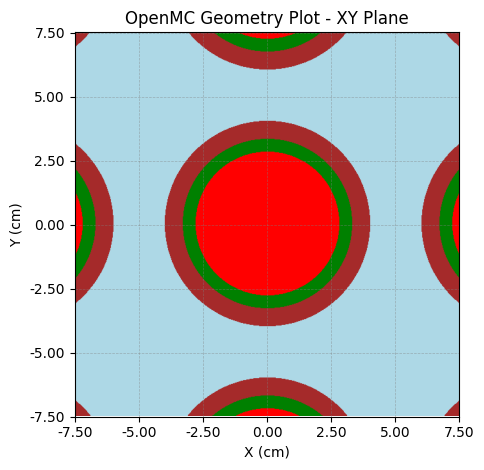

In [6]:
plot_geometry(materials=materials, width=15, height=15, saving_figure=False, color_by="material")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

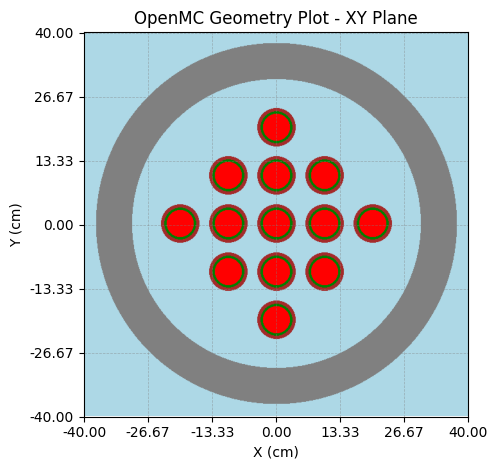

In [7]:
plot_geometry(materials=materials, width=80, height=80, saving_figure=False, color_by="material")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

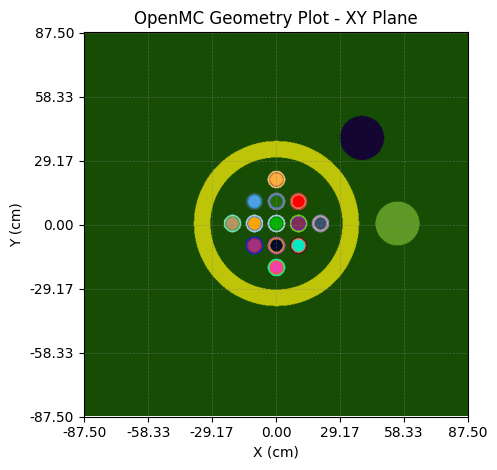

In [8]:
plot_geometry(materials=materials, width=175, height=175, saving_figure=False, color_by="cell", origin=(0, 0, 25.0))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

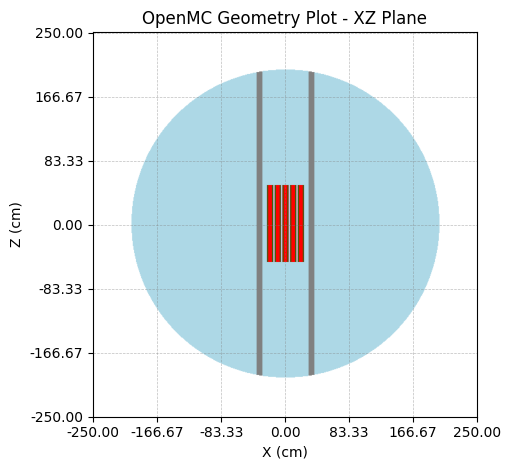

In [9]:
plot_geometry(materials=materials, width=500, height=500, plane="xz", saving_figure=False)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

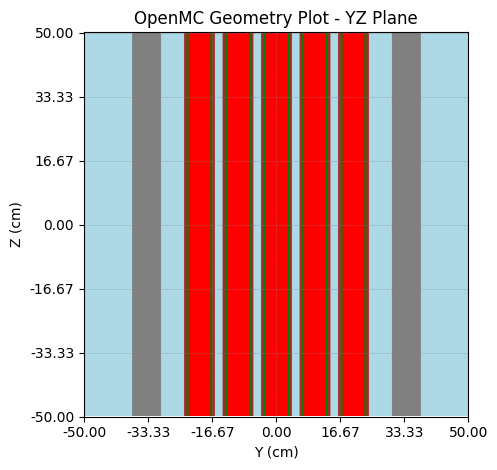

In [10]:
plot_geometry(materials=materials, width=100, height=100, plane="yz", saving_figure=False)

In [11]:
sources = []
z_bounds = [-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0]
probs = [0.1, 0.12, 0.14, 0.156, 0.16, 0.23, 0.25, 0.45, 0.3, 0.1]
total = sum(probs)
probs = [p / total for p in probs]

z_dist = openmc.stats.Tabular(z_bounds, probs, interpolation='histogram')

r = openmc.stats.PowerLaw(3.3, 4.0, 1.0) # from 3.3 to 4.0 cm
phi = openmc.stats.Uniform(0, 2*np.pi)
z = z_dist
for coords in CONTROL_RODS_DATA.values():
    x = coords["x"]
    y = coords["y"]
    source = openmc.IndependentSource()
    source.space = openmc.stats.CylindricalIndependent(r=r, phi=phi, z=z, origin=(x, y, 0))
    source.angle = openmc.stats.Isotropic()
    source.energy = openmc.stats.Discrete([1.1732e6,1.3325e6], [0.5, 0.5])
    source.strength = coords["activity"]  # Activity in Bq
    source.particle = "photon"
    sources.append(source)


In [ ]:
tallies = openmc.Tallies([])

mesh_tally_xy = mesh_tally_dose_plane(plane="xy", particule_type="photon", name_mesh_tally="flux_mesh_xy", thickness=4.0, coord_value=25.0)
tallies.append(mesh_tally_xy)

mesh_tally_yz = mesh_tally_dose_plane(plane="yz", particule_type="photon", name_mesh_tally="flux_mesh_yz", thickness=1.0, coord_value=0.0)
tallies.append(mesh_tally_yz)

In [13]:
tally_dose_photon = openmc.Tally(name="dose_tally_sphere_photons")
particule_type = 'photon' 
energy_bins, dose_coeffs = openmc.data.dose_coefficients(particle="photon", geometry="ISO")
energy_function_filter = openmc.EnergyFunctionFilter(energy_bins, dose_coeffs, interpolation='cubic')
cell_filter = openmc.CellFilter(detector_cell)
particle_filter = openmc.ParticleFilter([particule_type])
tally_dose_photon.filters = [cell_filter, particle_filter, energy_function_filter]
tally_dose_photon.scores = ['flux']
tallies.append(tally_dose_photon)

In [14]:
tally_dose_photon_45_deg = openmc.Tally(name="dose_tally_sphere_photons_45_deg")
particule_type = 'photon' 
cell_filter = openmc.CellFilter(detector_two_cell)
particle_filter = openmc.ParticleFilter([particule_type])
tally_dose_photon_45_deg.filters = [cell_filter, particle_filter, energy_function_filter]
tally_dose_photon_45_deg.scores = ['flux']
tallies.append(tally_dose_photon_45_deg)

In [ ]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 30
settings.batches = batches_number
settings.particles = 10**6
settings.source = sources
settings.uniform_source_sampling = True
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [16]:
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)


In [17]:
remove_previous_results(batches_number)
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [18]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/post_preocessing/post_processing.py:201: RuntimeWarning: invalid value encountered in divide
  flux_error = (flux_error * particles_per_second * 1e-6 * 3600 / mesh_bin_volume) / flux_data


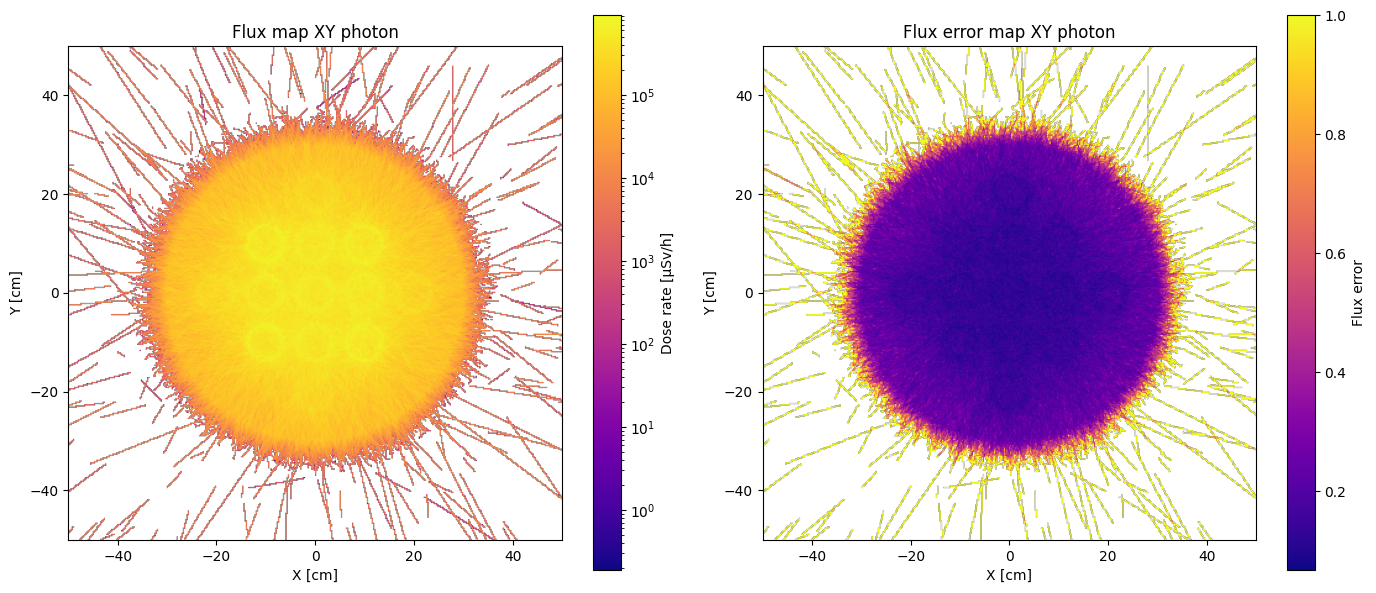

In [19]:
load_mesh_tally_dose(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_xy", particule_type="photon",
                plane = "xy", upper_right=(50, 50), lower_left=(-50, -50), 
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)

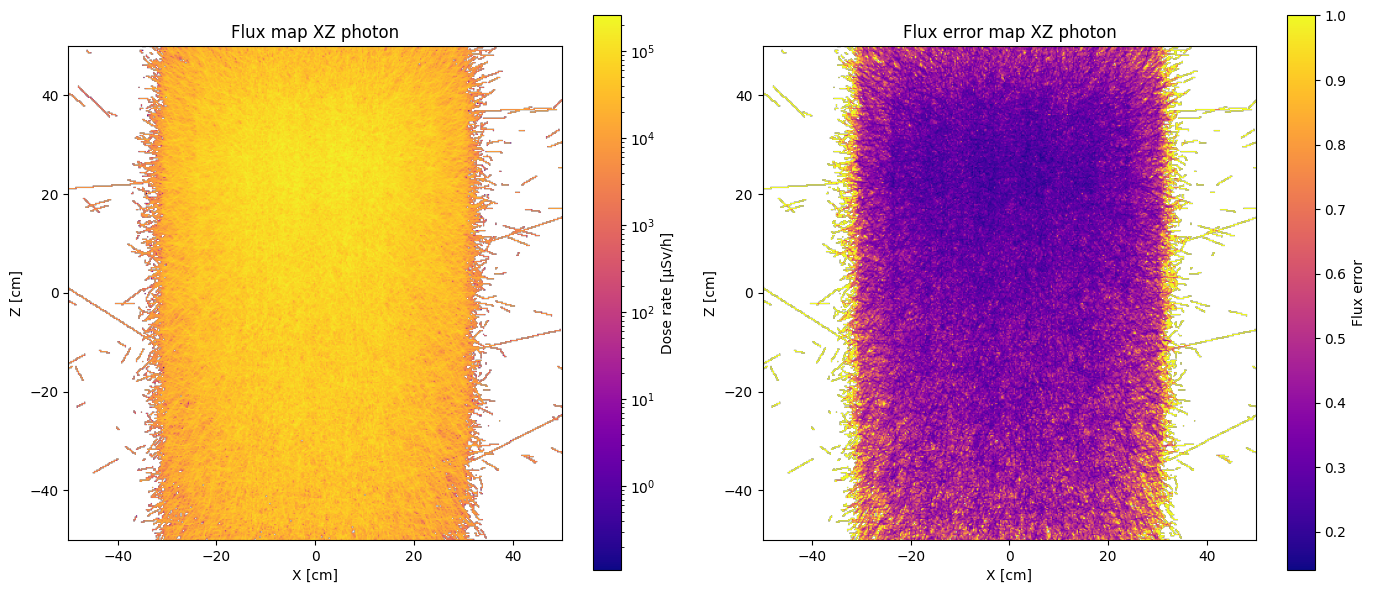

In [ ]:
load_mesh_tally_dose(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_yz", particule_type="photon",
                plane = "yz", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)

Débits de dose à proximité des barres de commande

In [21]:
dose_photon_result = sp.get_tally(name="dose_tally_sphere_photons")
dose_photon_45_deg_result = sp.get_tally(name="dose_tally_sphere_photons_45_deg")

dose_photon = dose_photon_result.mean.flatten()
dose_photon_std = dose_photon_result.std_dev.flatten()
dose_photon_45 = dose_photon_45_deg_result.mean.flatten()
dose_photon_45_std = dose_photon_45_deg_result.std_dev.flatten()

volume_cell_sphere_calculation = Volume_cell(detector_cell, surface_type=detector_cell.region.surface.type)

dose_results = {
    "detector": {
        "dose": dose_photon * (1e-6 * 3600) / volume_cell_sphere_calculation.get_volume(),
        "std": dose_photon_std * (1e-6 * 3600) / volume_cell_sphere_calculation.get_volume()
    },
    "detector_45_deg": {
        "dose": dose_photon_45 * (1e-6 * 3600) / volume_cell_sphere_calculation.get_volume(),
        "std": dose_photon_45_std * (1e-6 * 3600) / volume_cell_sphere_calculation.get_volume()
    }
}

print(f"Dose at detector: {dose_results['detector']['dose'][0]:.2e} ± {dose_results['detector']['std'][0]:.2e} µSv/h")
print(f"Relative error: {dose_results['detector']['std'][0] / dose_results['detector']['dose'][0]:.2%}")
print(f"Dose at detector 45°: {dose_results['detector_45_deg']['dose'][0]:.2e} ± {dose_results['detector_45_deg']['std'][0]:.2e} µSv/h")
print(f"Relative error: {dose_results['detector_45_deg']['std'][0] / dose_results['detector_45_deg']['dose'][0]:.2%}")


print(f"Dose at detector: {dose_results['detector']['dose'][0] * 1e-3:.2E} ± {dose_results['detector']['std'][0] * 1e-3:.2E} mSv/h")
print(f"Dose at detector 45°: {dose_results['detector_45_deg']['dose'][0] * 1e-3:.2E} ± {dose_results['detector_45_deg']['std'][0] * 1e-3:.2E} mSv/h")


Dose at detector: 1.28e+03 ± 2.87e+02 µSv/h
Relative error: 22.44%
Dose at detector 45°: 1.51e+03 ± 3.87e+02 µSv/h
Relative error: 25.63%
Dose at detector: 1.28E+00 ± 2.87E-01 mSv/h
Dose at detector 45°: 1.51E+00 ± 3.87E-01 mSv/h
